#Dataset

Para esse algoritmo temos uma base de dados com:
*   416 imagens de pacientes saudáveis
*   561 imagens de pacientes diagnosticados com cancer maligno
*   120 imagens de pacientes diagnosticados com cancer benigno
todas as imagens estão em formato .png, coletadas a partir de uma máquina de tomografia computadorizada, e cada paciente temos apenas 1 imagens.

Onde esse base de dados foi disponibilizada não há qualquer outra informação

Essa base de dados pode ser encontrada no site da Kaggle no link: https://www.kaggle.com/hamdallak/the-iqothnccd-lung-cancer-dataset/metadata

Obs.: As imagens de pacientes com cancer benigno não será considerada nesse código, pois, a quantidade de imagens disponibilizada não é suficiente para classificar entre as demais classes.

In [ ]:
# Permisão para acessar o google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#O problema
Classificar a imagem de CT-Scan, de pulmão, entre paciente com cancer maligno ou saúdavel.
O modelo será gerado sem estrutura apenas com leitura de imagem direto do diretório.

A baixo o modelo conceitual do algoritmo

![picture](https://drive.google.com/uc?export=view&id=1S5KX82yeArfL7BQ8gDM4XufcKZofFPFw)



##Imports

In [ ]:
# Bibliotecas utilizadas para o modelo de Transfer Learning
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Biblioteca utilizada para os calculos das metricas, de otimização e divisão estratificada dos dados
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Bibliotecas utilizadas para montagem do dataframe e gráficos
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Biblioteca para leitura de arquivo
import os

Para melhor desenpenho do algoritmo é utilizado uma GPU disponibilizada pela Google Colab

In [ ]:
# Verifica se a GPU está ligada

%tensorflow_version 2.x 
import tensorflow as tf 
device_name = tf.test.gpu_device_name() 
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not foud')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Leitura do diretório

In [ ]:
local ='/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/train'
folder = os.listdir(local)
print(folder)

['Malignant cases', 'Covid', 'Normal cases']


##Hyperparamentros

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training configuração
batch_size = 32
epochs = 100
classLabels=[0, 1]
datasetFolderName='DS'
MODEL_FILENAME="model_cv.h5"
sourceFiles=[]
# taxa de aprendizado
learning_rate = 0.001
alpha = 1e-5

# Inicialização da seed para que a validação sempre ocorra da mesma forma a cada teste
SEED = 17
np.random.seed(SEED) 

#Pré-processamento

Para o pré-processamento temos a organização dos dados em dataframes, identificação das classes, divisão entre teste e treinamento.

##Identificação das classes

In [ ]:
CATEGORIES = ['Malignant cases', 'Normal cases','Covid']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

3

Visualização da quantidade de imanges lidas para cada categoria

In [ ]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(local, category)))))

Malignant cases 459 images
Covid 364 images


Para o modelo, os caminhos para os arquivos foram estruturados no método data frame da biblioteca do pandas. Dessa forma é possível que cada imagem seja linkada a um index e assim sendo possível a manipulação das imagens sem saber qual é a classe da imagem. 

In [ ]:
dataset = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(local, category)):
        dataset.append(['{}/{}'.format(category, file), category_id, category])
dataset = pd.DataFrame(dataset, columns=['file', 'category_id', 'category'])
dataset.shape

(923, 3)

Embaralhar o dataframe. Caso o arquivo esteja com as classes organizadas, é necessario que faça o embaralhamento para evitar vies no treinamento

In [ ]:
dataset = dataset.sample(frac=1)
dataset.index = np.arange(len(dataset))
dataset.shape

dataset
train = dataset

##Particionamento da base de dados

A base de dados foi dividida entre treinamento(70%) e teste(30%) para que após o treinamento do modelo seja possível verificar se o modelo está generalizado. Assim, o resultado do teste é considerado o resultado final do projeto.

In [ ]:
#train, test = train_test_split( dataset, test_size=0.3, random_state=SEED, shuffle=False)
#train

#Aprendizado

Após a estruturação e divisão dos dados pode-se contruir o algoritmo de aprendizado de máquina, onde, é definido as metricas, métodos de otimização, métodos de aumento de dados (regularização) e a construção do modelo.


## Metrica

A metricas utilizadas são:
1.   Accuracy: Esta é a métrica mais simples. É basicamente o número de acertos (positivos) divido pelo número total de exemplos. Ela deve ser usada em datasets com a mesma proporção de exemplos para cada classe, e quando as penalidades de acerto e erro para cada classe forem as mesmas.

2.   Pressição: Número de exemplos classificados como pertencentes a uma classe, que realmente são daquela classe (positivos verdadeiros), dividido pela soma entre este número, e o número de exemplos classificados nesta classe, mas que pertencem a outras (falsos positivos).

3.   F1: O F1 Score é uma média harmônica entre precisão (que, apesar de ter o mesmo nome, não é a mesma citada acima) e recall. Veja abaixo as definições destes dois termos.

4.   Matriz de Confusão: Contagem de acertos e erros colocados em uma matriz, nela é possivel verificar os falsos-positivos, que indicam se o modelo está classificando uma pessoa sem cancer quando na verdade ela o tem.


In [ ]:
def my_metrics(y_true, y_pred):
    accuracy=accuracy_score(y_true, y_pred)
    precision=precision_score(y_true, y_pred,average='weighted')
    f1Score=f1_score(y_true, y_pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(y_true, y_pred)
    print(cm)
    
    return accuracy, precision, f1Score

### Visualização do gráficos

Plot do output da acuracia e da loss do modelo de treinamento e teste

In [ ]:
def printHistory(history, title):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  t = f.suptitle(title, fontsize=12)
  f.subplots_adjust(top=0.85, wspace=0.3)

  #epoch_list = list(range(1,epochs+1))
  ax1.plot(history.history['accuracy'], label='Train Accuracy')
  ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
  #ax1.set_xticks(np.arange(0, epochs+1, 5))
  ax1.set_ylabel('Accuracy Value')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Accuracy')
  ax1.legend(['Training', 'Validation'])
  #l1 = ax1.legend(loc="best")

  ax2.plot(history.history['loss'], label='Train Loss')
  ax2.plot(history.history['val_loss'], label='Validation Loss')
  #ax2.set_xticks(np.arange(0, epochs+1, 5))
  ax2.set_ylabel('Loss Value')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Loss')
  ax2.legend(['Training', 'Validation'])
  #l2 = ax2.legend(loc="best")

##Regularização
A técnica de regularização (https://www.deeplearningbook.org/) para diminuir o overfit que usamos é a Data Augmentation, esse método possibilita que aumentamos a quantidade de imagens e assim todos os milhões de paramentos presente na CNN seja utilizado e assim aumentando a generalização do modelo. As combinações realizadas no conjunto de treinamento foram:

* Normalização dos valores dos pixel da imagem
* Zoom
* Rotação
* Preenchimento
* Achatamento e alongamento

Contudo, o flip não será utilizado, nem horizontal e nem vertical, pois o pulmão direito tem suas diferenças importantes com relação ao pulmão esquerdo.


In [ ]:
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     zoom_range=0.20, 
                                     fill_mode="nearest", 
                                     rotation_range=20, 
                                     width_shift_range=0.2, 
                                     height_shift_range=0.2, 
                                     horizontal_flip=False)
  
  validation_datagen = ImageDataGenerator(rescale=1./255)

##Modelo: transfer learning - VGG19

O modelo utilizado foi de transferLaning. O transfer Learning surgiu com desafio de imagenet que possui 12 milhões de imagens e o objetivo era categorizar mais de mil classes diferentes. E aos poucos foram criadas as diversas redes neurais.Para esse código foi utilizado o VGG19.

Na VGG-19 foi inserido os pesos da imagnet, não foi incluído o toda da rede neural e com imagens as imagens com RGB. Como a VGG-19 possui milhões de parâmetros treináveis, para reduzir a computação será treinado apenas as camadas mais profundas. As camadas iniciais aprendem com características muito gerais e a média que ela se aprofunda nas camadas tende a aprender padrões mais específicos para o problema. Sendo assim, a partir do block5_conv1 será o início do treinamento da rede neural.

Para o modelo é adicionado a VGG-19 com a rede Dense com 128 neurônios, depois adicionado a camada de pooling (redução de de resolução) pela média, também é adicionado a Flaten para que a computação entenda melhor a imagem. Para reduzir o overfitting foi utilizado a  técnica de método do dropout o qual irá desligar 5 neurônios e tenta treinar com esse 5 neurônios e assim conseguir regularizar a rede neural, e a técnica de Batch Normalization que durante o treinamento é feito a normalização a cada passada por neurônios e isso irá aumentar a estabilidade da rede neural.

E para a compilação do modelo é utilizado uma Binary Cross Entropy, o otimizador Adam, e como métrica a acurácia.

In [ ]:
def createModel():
  # Building Model  ===>shape 150 ou 224??
  vggModel = ResNet50(weights="imagenet", include_top=False,
                  input_tensor=Input(shape=(224, 224, 3)))

  #ajuste fino
  vggModel.trainable = True
  set_trainable = False
  for layer in vggModel.layers:
    if layer.name == 'block5_conv1':
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

  model = models.Sequential()
  model.add(vggModel)
  model.add(layers.GlobalAveragePooling2D()) #redução de resolução pela media global
  model.add(layers.BatchNormalization())#aplica normalizações durante a troca de neuronios
  model.add(layers.Flatten()) #transforma a imagem
  model.add(layers.Dense(128,activation='relu'))#camada densa de 128 neuronios
  model.add(layers.Dropout(0.5)) #delisga 5 neronios e treina com eles, generalizar a rede diminuindo overfit
  model.add(layers.Dense(3, activation='softmax'))

  #opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
  model.compile( loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

  return model

### Otimização do modelo de treinamento

Para a otimização é utilizado 

*   Reduce Plateau para minimizar a função objetivo. 

Com isso é possível encontrar um o mínimo local, e para reduzir a taxa de aprendizado pelo fato caso não ocorra mudança na. Quando a perda não for alterada a acurácia atual muda para algo pior para que seja possível encontrar o mínimo global. 

*   ModelChecpoint

Reesponsavel por analizar todas as interações do modelo e salvar o melhor modelo para que possamos ulizar ele para a verificação da generalização do modelo

In [ ]:
#callbacks for keras modal
def get_callbacks():
    print("Get Callbacks")

    lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=1e-5, patience=5, verbose=1)
    checkpoint = ModelCheckpoint('/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/BESTcallback_weights_resnetMISTO.hdf5', save_best_only=True)
    return [lr_reduce, checkpoint]

##CrossValidation

Depois do particionamento do dataset o treinamento terá com um processo de validação cruzada para poder gerar um modelo generaliza.

Mais uma vez os dados serão divididos, porém, agora em k partes e, em seguida, testar os modelos apenas uma parte dos dados. Isso é chamado de validação cruzada k-fold. Não apenas fornece a estimativa de desempenho, mas também é possível verificar a propagação do erro. Os dados são divididos em K partes, para cada uma dessas partes, o modelo irá usar a parte K-1 para treinar, enquanto usará 1 parte para validar. Ao final do processo, quando o modelo iterar todas as k vezes, obtém-se um verdadeiro score de como seu modelo está generalizando. Para a  presente aplicação foi adotado k igual a 3.

A divisão entre os folds foram com estratificação a qual faz a divisão de cada fold com o mesma quantidade de cada classe em cada um

In [ ]:
skf = StratifiedKFold(3, random_state = 0, shuffle = True) 

## Modelo

Found 548 validated image filenames belonging to 2 classes.
Found 275 validated image filenames belonging to 2 classes.
Get Callbacks


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
17/17 [==============================] - 155s 9s/step - loss: 0.3746 - accuracy: 0.8230 - val_loss: 0.8224 - val_accuracy: 0.5564


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
17/17 [==============================] - 11s 651ms/step - loss: 0.1764 - accuracy: 0.9453 - val_loss: 1.0372 - val_accuracy: 0.5564
Epoch 3/100
17/17 [==============================] - 11s 660ms/step - loss: 0.1298 - accuracy: 0.9635 - val_loss: 1.1405 - val_accuracy: 0.5564
Epoch 4/100
17/17 [==============================] - 12s 683ms/step - loss: 0.1213 - accuracy: 0.9562 - val_loss: 1.2391 - val_accuracy: 0.5564
Epoch 5/100
17/17 [==============================] - 11s 683ms/step - loss: 0.1086 - accuracy: 0.9562 - val_loss: 1.0677 - val_accuracy: 0.5564
Epoch 6/100
17/17 [==============================] - 11s 633ms/step - loss: 0.1091 - accuracy: 0.9617 - val_loss: 1.0094 - val_accuracy: 0.5564

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
17/17 [==============================] - 11s 635ms/step - loss: 0.0861 - accuracy: 0.9726 - val_loss: 0.8730 - val_accuracy: 0.5564
Epoch 8/100
17/17 [==============================] - 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


9/9 [==============================] - 3s 207ms/step
***Performance on Validation data***
Accuracy  : 0.9890909090909091
Precision : 0.989108082000644
f1Score : 0.9890862296508334
[[120   2]
 [  1 152]]
9/9 [==============================] - 2s 223ms/step - loss: 0.0288 - accuracy: 0.9891
Found 549 validated image filenames belonging to 2 classes.
Found 274 validated image filenames belonging to 2 classes.
Get Callbacks


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
17/17 [==============================] - 15s 747ms/step - loss: 0.3317 - accuracy: 0.8543 - val_loss: 0.6640 - val_accuracy: 0.5584


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
17/17 [==============================] - 12s 682ms/step - loss: 0.1685 - accuracy: 0.9417 - val_loss: 1.1138 - val_accuracy: 0.5584
Epoch 3/100
17/17 [==============================] - 11s 650ms/step - loss: 0.1444 - accuracy: 0.9454 - val_loss: 1.1262 - val_accuracy: 0.5584
Epoch 4/100
17/17 [==============================] - 11s 628ms/step - loss: 0.1679 - accuracy: 0.9454 - val_loss: 1.1233 - val_accuracy: 0.5584
Epoch 5/100
17/17 [==============================] - 11s 623ms/step - loss: 0.1119 - accuracy: 0.9581 - val_loss: 0.9777 - val_accuracy: 0.5584
Epoch 6/100
17/17 [==============================] - 11s 675ms/step - loss: 0.1403 - accuracy: 0.9454 - val_loss: 0.7014 - val_accuracy: 0.5584

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
17/17 [==============================] - 12s 676ms/step - loss: 0.0737 - accuracy: 0.9745 - val_loss: 0.6302 - val_accuracy: 0.5584
Epoch 8/100
17/17 [==============================] - 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


9/9 [==============================] - 3s 196ms/step
***Performance on Validation data***
Accuracy  : 0.9963503649635036
Precision : 0.996374063892312
f1Score : 0.9963487371375856
[[120   1]
 [  0 153]]
9/9 [==============================] - 2s 209ms/step - loss: 0.0279 - accuracy: 0.9964
Found 549 validated image filenames belonging to 2 classes.
Found 274 validated image filenames belonging to 2 classes.
Get Callbacks


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
17/17 [==============================] - 14s 679ms/step - loss: 0.3609 - accuracy: 0.8379 - val_loss: 0.9113 - val_accuracy: 0.5584


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
17/17 [==============================] - 12s 684ms/step - loss: 0.1616 - accuracy: 0.9526 - val_loss: 1.4212 - val_accuracy: 0.5584
Epoch 3/100
17/17 [==============================] - 11s 635ms/step - loss: 0.1456 - accuracy: 0.9563 - val_loss: 1.3859 - val_accuracy: 0.5584
Epoch 4/100
17/17 [==============================] - 11s 622ms/step - loss: 0.1031 - accuracy: 0.9636 - val_loss: 1.1789 - val_accuracy: 0.5584
Epoch 5/100
17/17 [==============================] - 11s 625ms/step - loss: 0.0797 - accuracy: 0.9745 - val_loss: 1.0710 - val_accuracy: 0.5584
Epoch 6/100
17/17 [==============================] - 11s 653ms/step - loss: 0.0768 - accuracy: 0.9745 - val_loss: 1.2297 - val_accuracy: 0.5584

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/100
17/17 [==============================] - 11s 664ms/step - loss: 0.0891 - accuracy: 0.9672 - val_loss: 1.0676 - val_accuracy: 0.5584
Epoch 8/100
17/17 [==============================] - 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


9/9 [==============================] - 3s 215ms/step
***Performance on Validation data***
Accuracy  : 0.9927007299270073
Precision : 0.9927007299270073
f1Score : 0.9927007299270073
[[120   1]
 [  1 152]]
9/9 [==============================] - 2s 227ms/step - loss: 0.0281 - accuracy: 0.9927


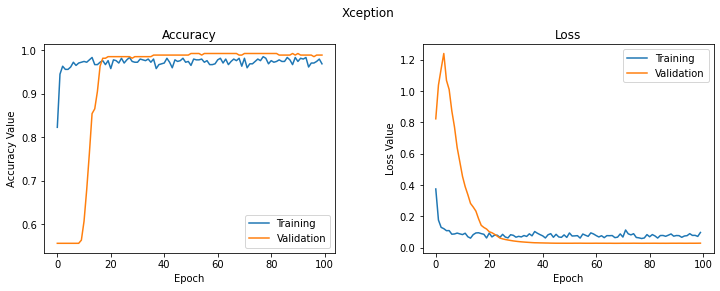

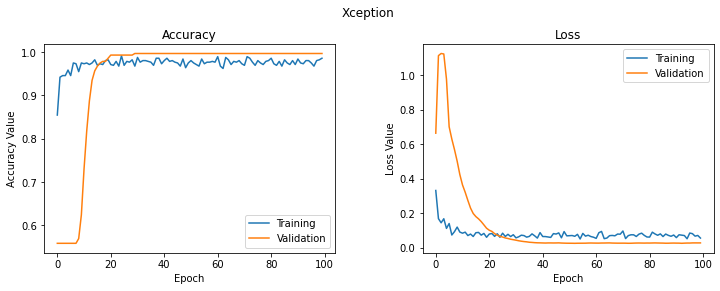

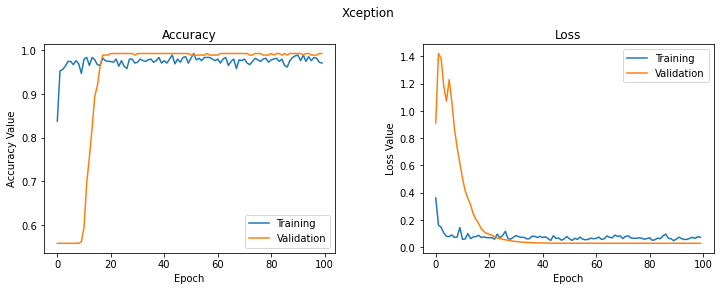

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 0
t = train.category_id

for train_index, valid_index in skf.split(np.zeros(len(t)), t): 

  fold_var+=1

  train_kf = train.loc[train_index]
  valid_kf = train.loc[valid_index]
 
  model = createModel()

       
  #Start ImageClassification Model
  train_generator = train_datagen.flow_from_dataframe(dataframe=train_kf,
                                            directory=local,
                                            x_col="file",
                                            y_col="category",
                                            batch_size=batch_size,
                                            seed=17,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(224, 224));

  valid_generator=validation_datagen.flow_from_dataframe(dataframe=valid_kf,
                                            directory=local,
                                            x_col="file",
                                            y_col="category",
                                            batch_size=batch_size,
                                            seed=17,
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=(224, 224));

  
  # fit model
  history=model.fit_generator(generator = train_generator, 
                              validation_data = valid_generator,
                              steps_per_epoch= train_generator.n / train_generator.batch_size,
                              validation_steps= valid_generator.n / valid_generator.batch_size,
                              epochs=epochs,
                              verbose = 1,
                              callbacks = get_callbacks())

  predictions = model.predict_generator(valid_generator, verbose=1)
  yPredictions = np.argmax(predictions, axis=1)
  true_classes = valid_generator.classes

  # evaluate validation performance
  print("***Performance on Validation data***")    
  valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)
  
  printHistory(history, "Xception")


  results = model.evaluate(valid_generator)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()


### Salvar Modelo

Salvar o modelo treinado para que seja possivel verificar se o modelo classifica corretamente a partir do conjunto de teste e ser utilizado em uma aplicação

In [ ]:
model.save("/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/resnetMISTO.h5")
model.save_weights("/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/resnetCANCER_weights_MISTO.hdf5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#Predição

Carregar o modelo de treinamento para a verificação da generalização a partir do conjunto de teste

In [ ]:
# Load saved model
model = load_model('/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/resnetMISTO.h5')

Visualização do conjunto de teste

In [ ]:
test_path ='/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/test'


test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_path, category)):
        test.append(['{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape
test

,file,category_id,category
0,Malignant cases/Malignant case (103).jpg,0,Malignant cases
1,Malignant cases/Malignant case (10).jpg,0,Malignant cases
2,Malignant cases/Malignant case (1).jpg,0,Malignant cases
3,Malignant cases/Malignant case (109).jpg,0,Malignant cases
4,Malignant cases/Malignant case (118).jpg,0,Malignant cases
...,...,...,...
253,Covid/Covid (1017).png,1,Covid
254,Covid/Covid (1124).png,1,Covid
255,Covid/Covid (105).png,1,Covid
256,Covid/Covid (1015).png,1,Covid


Insere o conjunto de teste no modelo de treinamente e com isso visualizar o resultado final, neste caso é uma simulação de uma caso real

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
print("==============TEST RESULTS============")


test_generator = test_datagen.flow_from_dataframe(dataframe=test,
                                                  directory=test_path,
                                                x_col="file",
                                                y_col='category',
                                                batch_size=10,
                                                shuffle=False,
                                                class_mode='categorical',
                                                target_size=(224, 224),
                                                validate_filenames=False)

predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)
model.save('/content/drive/MyDrive/COVID/COVID/CODIGOS/conjuntoImagem/resnetMISTO_teste.h5')

==============TEST RESULTS============
Found 258 non-validated image filenames belonging to 2 classes.
26/26 [==============================] - 71s 3s/step
Accuracy  : 0.9922480620155039
Precision : 0.992397137745975
f1Score : 0.992260686530856
[[154   2]
 [  0 102]]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


##Ensemble

In [ ]:
'''model1 = load_model('/content/drive/MyDrive/COVID/COVID/CODIGOS/modelo/callback_weightsIN.hdf5')
model2 = load_model('/content/drive/MyDrive/COVID/COVID/CODIGOS/modelo/callback_weightsRESNET.hdf5')
model3 = load_model('/content/drive/MyDrive/COVID/COVID/CODIGOS/modelo/callback_weightsVGG.hdf5')
model4 = load_model('/content/drive/MyDrive/COVID/COVID/CODIGOS/modelo/callback_weightsVGG.hdf5')

models = [model1, model2, model3, model4]
models = [model1, model2, model3, model4]
preds1 = [model.predict(test_generator, verbose=1) for model in models]
preds1 = np.array(preds1)
true_classes = test_generator.classes'''

In [ ]:
'''
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            for w4 in range(0,5):
                wts = [w1/10., w2/10., w3/10., w4/10.]
                wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
                wetd_ensemble_pred = np.argmax(wted_preds1, axis=1)
                weighted_accuracy1 = accuracy_score(true_classes, wetd_ensemble_pred)
                df= df.append(pd.DataFrame({'w1': wts[0], 'w2': wts[1], 'w3': wts[2], 'w4': wts[3], 'acc': weighted_accuracy1*100}, index=[0]), ignore_index=True)

                              
max_acc_row = df.iloc[df['acc'].idxmax()]
print('max acc: ', max_acc_row[0], 'w1: ', max_acc_row[1], 'w2: ', max_acc_row[2], 'w3: ', max_acc_row[3], 'w4: ', max_acc_row[4])

'''

In [ ]:
'''testAcc,testPrec, testFScore = my_metrics(true_classes, wetd_ensemble_pred)'''